In [3]:
import pandas as pd
import numpy as np

# Cargo la base limpia con la que hemos venido trabajando
df = pd.read_csv("df_cleaned.csv")

# Aseguro tipos básicos que voy a usar
df["price"] = df["price"].astype(float)
df["accommodates"] = df["accommodates"].astype(int)

# Precio por huésped como indicador de valor relativo
df["price_per_guest"] = df["price"] / df["accommodates"]

# Reconstruyo el borough a partir de las dummies de neighbourhood_group_cleansed
borough_cols = [
    "neighbourhood_group_cleansed:Bronx",
    "neighbourhood_group_cleansed:Brooklyn",
    "neighbourhood_group_cleansed:Manhattan",
    "neighbourhood_group_cleansed:Queens",
    "neighbourhood_group_cleansed:Staten Island"
]

df["borough_seg"] = (
    df[borough_cols]
      .idxmax(axis=1)          # columna que tiene el 1
      .str.split(":", n=1)
      .str[1]                  # me quedo con Bronx, Brooklyn, etc.
)

# Reconstruyo el tipo de habitación a partir de las dummies de room_type
room_cols = [
    "room_type:Entire home/apt",
    "room_type:Hotel room",
    "room_type:Private room",
    "room_type:Shared room"
]

df["room_type_seg"] = (
    df[room_cols]
      .idxmax(axis=1)
      .str.split(":", n=1)
      .str[1]
)

# Reviso rápido que las nuevas columnas tengan sentido
print(df[["price", "accommodates", "price_per_guest", "borough_seg", "room_type_seg"]].head())

# Guardo esta base intermedia para el modelo 3
df.to_csv("df_modelo3_segmentos_base.csv", index=False)


   price  accommodates  price_per_guest borough_seg    room_type_seg
0   66.0             1        66.000000      Queens     Private room
1   76.0             1        76.000000   Manhattan     Private room
2   97.0             6        16.166667      Queens  Entire home/apt
3   60.0             1        60.000000    Brooklyn     Private room
4  425.0             6        70.833333    Brooklyn  Entire home/apt


In [4]:
# Cargo la base intermedia generada en el commit 1
df = pd.read_csv("df_modelo3_segmentos_base.csv")

# Defino el segmento comparable: mismo borough + mismo tipo de habitación
segment_cols = ["borough_seg", "room_type_seg"]

# Para cada segmento calculo:
# - percentil 25 y 75 de price_per_guest (rango razonable de precio por huésped)
# - mediana de amenities_count (mínimo razonable de amenidades)
segment_stats = (
    df.groupby(segment_cols)
      .agg(
          p25_ppg=("price_per_guest", lambda x: np.percentile(x, 25)),
          p75_ppg=("price_per_guest", lambda x: np.percentile(x, 75)),
          med_amenities=("amenities_count", "median")
      )
      .reset_index()
)

# Uno estas estadísticas al dataframe principal
df = df.merge(segment_stats, on=segment_cols, how="left")

# Regla de recomendación:
# - price_per_guest entre p25 y p75 del segmento
# - amenities_count >= med_amenities del segmento
cond_precio = (df["price_per_guest"] >= df["p25_ppg"]) & (df["price_per_guest"] <= df["p75_ppg"])
cond_amenities = df["amenities_count"] >= df["med_amenities"]

df["recommended"] = np.where(cond_precio & cond_amenities, 1, 0)

# Reviso que la etiqueta no quede extremadamente desbalanceada
print("Distribución de la etiqueta recommended:")
print(df["recommended"].value_counts(dropna=False))
print(df["recommended"].value_counts(normalize=True).round(3))

# Guardo la base final para el modelo de clasificación
df.to_csv("df_modelo3_clasificacion.csv", index=False)

Distribución de la etiqueta recommended:
recommended
0    15283
1     5544
Name: count, dtype: int64
recommended
0    0.734
1    0.266
Name: proportion, dtype: float64


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Cargo la base ya con la etiqueta recommended
df = pd.read_csv("df_modelo3_clasificacion.csv")

# Variable objetivo: recommended (0 = no recomendada, 1 = recomendada)
y = df["recommended"].astype(int)

print("Distribución de la clase objetivo:")
print(y.value_counts(dropna=False))
print(y.value_counts(normalize=True).round(3))

# Defino qué columnas NO quiero usar como features
# (target, textos, columnas de ayuda para construir la etiqueta, etc.)
cols_excluir = [
    "recommended",          # target
    "amenities",            # lista de amenities en texto
    "bathrooms_text",       # texto descriptivo del baño
    "calendar_last_scraped",
    "host_since",
    "host_response_time",
    "price_range",
    "borough_seg",          # ya se usó para definir la regla de negocio
    "room_type_seg",        # igual
    "p25_ppg",
    "p75_ppg",
    "med_amenities"
]

# Me quedo solo con las columnas que sí van a entrar al modelo
# (tanto numéricas como dummies que ya vienen en el dataset)
cols_features = [c for c in df.columns if c not in cols_excluir]

X = df[cols_features].copy()

print("\nNúmero de variables explicativas seleccionadas:", X.shape[1])

# Split train / test estratificado para respetar la proporción de clases
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Tamaños de los conjuntos:")
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)

# Escalado estándar de todas las features (los dummies pasan de 0/1 a valores centrados, lo cual está bien para la red)
scaler_clf = StandardScaler()
scaler_clf.fit(X_train)

X_train_scaled = scaler_clf.transform(X_train)
X_test_scaled = scaler_clf.transform(X_test)

# Paso a float32 por compatibilidad con TensorFlow
X_train_scaled = X_train_scaled.astype("float32")
X_test_scaled = X_test_scaled.astype("float32")

y_train = y_train.values.astype("float32")
y_test = y_test.values.astype("float32")

print("\nEjemplo de fila escalada:")
print(X_train_scaled[0][:10])


Distribución de la clase objetivo:
recommended
0    15283
1     5544
Name: count, dtype: int64
recommended
0    0.734
1    0.266
Name: proportion, dtype: float64

Número de variables explicativas seleccionadas: 100
Tamaños de los conjuntos:
X_train: (16661, 100)
X_test : (4166, 100)

Ejemplo de fila escalada:
[-3.9586241  -2.802569    0.12077124  1.4168756  -0.43168676 -0.3549193
 -0.37398288 -0.54305923 -0.13032001  0.14498988]


In [6]:
import tensorflow as tf

# Dejo fija la semilla para que el entrenamiento sea replicable
tf.random.set_seed(42)
tf.keras.backend.clear_session()

# Dimensión de entrada = número de features escaladas
input_dim = X_train_scaled.shape[1]
print("Dimensión de entrada del modelo de clasificación:", input_dim)

# Armo un MLP sencillo como baseline para clasificación binaria
modelo_clf = tf.keras.Sequential()
modelo_clf.add(tf.keras.layers.InputLayer(input_shape=(input_dim,)))
modelo_clf.add(tf.keras.layers.Dense(32, activation="relu"))
modelo_clf.add(tf.keras.layers.Dense(16, activation="relu"))
modelo_clf.add(tf.keras.layers.Dense(1, activation="sigmoid"))  # salida en [0,1] para probabilidad de recommended

modelo_clf.summary()

# Para clasificación binaria:
# - loss: binary_crossentropy
# - optimizer: adam (funciona bien por defecto)
# - métricas: accuracy + precision + recall para ver balance
modelo_clf.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ]
)

# Early stopping para no sobreentrenar cuando la val_loss deje de mejorar
early_stop_clf = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=8,
    restore_best_weights=True
)

# Entreno el modelo con un 20% del train como validación interna
history_clf = modelo_clf.fit(
    X_train_scaled,
    y_train,
    epochs=60,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stop_clf],
    verbose=1
)

# Guardo el historial en un DataFrame si luego quiero graficar
import pandas as pd

hist_clf = pd.DataFrame(history_clf.history)
hist_clf["epoch"] = history_clf.epoch

print("\nÚltimos valores de métricas en entrenamiento:")
print(hist_clf.tail(1)[["loss", "val_loss", "accuracy", "val_accuracy", "precision", "val_precision", "recall", "val_recall"]])



Dimensión de entrada del modelo de clasificación: 100


c:\Users\14 cf037la\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,777 (14.75 KB)

 Trainable params: 3,777 (14.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6873 - loss: 0.5971 - precision: 0.3347 - recall: 0.1833 - val_accuracy: 0.7303 - val_loss: 0.5201 - val_precision: 0.5422 - val_recall: 0.0497
Epoch 2/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7439 - loss: 0.4777 - precision: 0.5472 - recall: 0.1904 - val_accuracy: 0.7525 - val_loss: 0.4666 - val_precision: 0.5864 - val_recall: 0.3035
Epoch 3/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7613 - loss: 0.4406 - precision: 0.5793 - recall: 0.3602 - val_accuracy: 0.7576 - val_loss: 0.4470 - val_precision: 0.5819 - val_recall: 0.3841
Epoch 4/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7686 - loss: 0.4226 - precision: 0.5927 - recall: 0.4029 - val_accuracy: 0.7606 - val_loss: 0.4355 - val_precision: 0.5854 - val_recall: 0.4084
Epoch 5/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7739 - loss: 0.4106 - precision: 0.6019 - recall: 0.4310 - val_accuracy: 0.7645 - val_loss: 0.4283 - v

131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Matriz de confusión (valores):
[[2673  384]
 [ 438  671]]


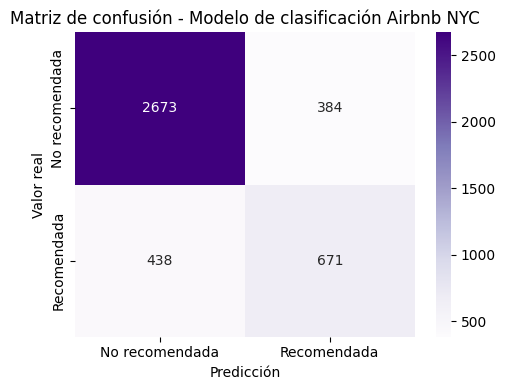


Métricas en el conjunto de prueba:
Accuracy : 0.8027
Precision: 0.6360
Recall   : 0.6050
F1-score : 0.6201
AUC ROC  : 0.8830

Reporte de clasificación completo:
                precision    recall  f1-score   support

No recomendada       0.86      0.87      0.87      3057
   Recomendada       0.64      0.61      0.62      1109

      accuracy                           0.80      4166
     macro avg       0.75      0.74      0.74      4166
  weighted avg       0.80      0.80      0.80      4166



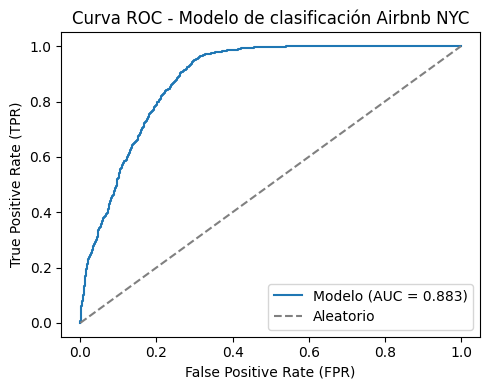

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

# Predicciones de probabilidad en el conjunto de prueba
y_pred_prob = modelo_clf.predict(X_test_scaled)

# Umbral estándar 0.5 para pasar de probabilidad a clase 0/1
y_pred = (y_pred_prob >= 0.5).astype(int).ravel()

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

print("Matriz de confusión (valores):")
print(cm)

# Heatmap de matriz de confusión en tonos morados
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Purples",
    xticklabels=["No recomendada", "Recomendada"],
    yticklabels=["No recomendada", "Recomendada"]
)
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de confusión - Modelo de clasificación Airbnb NYC")
plt.tight_layout()
plt.show()

# Métricas básicas
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_pred_prob)

print("\nMétricas en el conjunto de prueba:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"AUC ROC  : {auc:.4f}")

# Reporte de clasificación detallado por clase
print("\nReporte de clasificación completo:")
print(classification_report(y_test, y_pred, target_names=["No recomendada", "Recomendada"], zero_division=0))

# Curva ROC para tener una visual rápida de discriminación del modelo
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"Modelo (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Aleatorio")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Curva ROC - Modelo de clasificación Airbnb NYC")
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

# Función auxiliar para armar redes MLP de clasificación binaria
def build_clf_mlp(n_hidden_layers, units_per_layer, dropout_rate=0.0, input_dim=None):
    """
    Arma un MLP sencillo para clasificación binaria.
    Permite variar número de capas, unidades y dropout.
    """
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(input_dim,)))
    
    # Capas ocultas
    for _ in range(n_hidden_layers):
        model.add(tf.keras.layers.Dense(units_per_layer, activation="relu"))
        if dropout_rate > 0:
            model.add(tf.keras.layers.Dropout(dropout_rate))
    
    # Capa de salida binaria
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy",
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall")
        ]
    )
    return model

# Dimensión de entrada (ya la habíamos usado para el baseline)
input_dim = X_train_scaled.shape[1]
print("Input dim para la búsqueda de modelos:", input_dim)

# Defino a mano unas cuantas configuraciones razonables
clf_configs = [
    {"name": "clf_16",        "n_layers": 1, "units": 16, "dropout": 0.00},
    {"name": "clf_32_16",     "n_layers": 2, "units": 32, "dropout": 0.05},
    {"name": "clf_64_32",     "n_layers": 2, "units": 64, "dropout": 0.10},  # un poco más grande
    {"name": "clf_32_32_16",  "n_layers": 3, "units": 32, "dropout": 0.10},
    {"name": "clf_64_64",     "n_layers": 2, "units": 64, "dropout": 0.15}   # algo más agresivo con dropout
]

clf_results = []

for cfg in clf_configs:
    print("\n====================================")
    print(f"Entrenando modelo: {cfg['name']}")
    print(f"Capas: {cfg['n_layers']}, unidades: {cfg['units']}, dropout: {cfg['dropout']}")
    
    # Fijo semilla y limpio sesión para que cada modelo arranque "desde cero"
    tf.random.set_seed(42)
    tf.keras.backend.clear_session()
    
    # Armo el modelo con la configuración actual
    model_tmp = build_clf_mlp(
        n_hidden_layers=cfg["n_layers"],
        units_per_layer=cfg["units"],
        dropout_rate=cfg["dropout"],
        input_dim=input_dim
    )
    
    # Early stopping sencillo para no sobreentrenar
    early_stop_tmp = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=6,
        restore_best_weights=True
    )
    
    # Entrenamiento
    history_tmp = model_tmp.fit(
        X_train_scaled,
        y_train,
        epochs=50,
        batch_size=256,
        validation_split=0.2,
        callbacks=[early_stop_tmp],
        verbose=0  # si quieres ver las épocas, cámbialo a 1
    )
    
    # Predicciones en test
    y_pred_prob_tmp = model_tmp.predict(X_test_scaled, verbose=0).flatten()
    y_pred_tmp = (y_pred_prob_tmp >= 0.5).astype(int)
    
    # Métricas en test
    acc = accuracy_score(y_test, y_pred_tmp)
    prec = precision_score(y_test, y_pred_tmp, zero_division=0)
    rec = recall_score(y_test, y_pred_tmp, zero_division=0)
    f1 = f1_score(y_test, y_pred_tmp, zero_division=0)
    auc = roc_auc_score(y_test, y_pred_prob_tmp)
    
    epochs_trained = len(history_tmp.history["loss"])
    
    clf_results.append({
        "name": cfg["name"],
        "n_layers": cfg["n_layers"],
        "units": cfg["units"],
        "dropout": cfg["dropout"],
        "epochs_trained": epochs_trained,
        "acc_test": acc,
        "precision_test": prec,
        "recall_test": rec,
        "f1_test": f1,
        "auc_test": auc,
        "model_obj": model_tmp,
        "history": history_tmp
    })
    
    print(f"Accuracy test : {acc:.4f}")
    print(f"Precision test: {prec:.4f}")
    print(f"Recall test   : {rec:.4f}")
    print(f"F1 test       : {f1:.4f}")
    print(f"AUC test      : {auc:.4f}")
    print(f"Épocas entrenadas: {epochs_trained}")

# Paso los resultados a DataFrame para verlo ordenado
clf_results_df = pd.DataFrame(clf_results)
clf_results_df = clf_results_df.sort_values(by="f1_test", ascending=False)

print("\nResumen ordenado por F1 en test (mejor primero):")
print(clf_results_df[[
    "name", "n_layers", "units", "dropout",
    "epochs_trained", "acc_test", "precision_test", "recall_test", "f1_test", "auc_test"
]])


Input dim para la búsqueda de modelos: 100

Entrenando modelo: clf_16
Capas: 1, unidades: 16, dropout: 0.0


c:\Users\14 cf037la\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Accuracy test : 0.8101
Precision test: 0.6494
Recall test   : 0.6231
F1 test       : 0.6360
AUC test      : 0.8861
Épocas entrenadas: 50

Entrenando modelo: clf_32_16
Capas: 2, unidades: 32, dropout: 0.05


c:\Users\14 cf037la\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Accuracy test : 0.8140
Precision test: 0.6494
Recall test   : 0.6546
F1 test       : 0.6520
AUC test      : 0.8928
Épocas entrenadas: 37

Entrenando modelo: clf_64_32
Capas: 2, unidades: 64, dropout: 0.1


c:\Users\14 cf037la\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Accuracy test : 0.8118
Precision test: 0.6452
Recall test   : 0.6510
F1 test       : 0.6481
AUC test      : 0.8959
Épocas entrenadas: 37

Entrenando modelo: clf_32_32_16
Capas: 3, unidades: 32, dropout: 0.1


c:\Users\14 cf037la\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Accuracy test : 0.8092
Precision test: 0.6311
Recall test   : 0.6817
F1 test       : 0.6554
AUC test      : 0.8919
Épocas entrenadas: 46

Entrenando modelo: clf_64_64
Capas: 2, unidades: 64, dropout: 0.15


c:\Users\14 cf037la\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Accuracy test : 0.8017
Precision test: 0.6290
Recall test   : 0.6222
F1 test       : 0.6256
AUC test      : 0.8865
Épocas entrenadas: 31

Resumen ordenado por F1 en test (mejor primero):
           name  n_layers  units  dropout  epochs_trained  acc_test  \
3  clf_32_32_16         3     32     0.10              46  0.809169   
1     clf_32_16         2     32     0.05              37  0.813970   
2     clf_64_32         2     64     0.10              37  0.811810   
0        clf_16         1     16     0.00              50  0.810130   
4     clf_64_64         2     64     0.15              31  0.801728   

   precision_test  recall_test   f1_test  auc_test  
3        0.631052     0.681695  0.655397  0.891929  
1        0.649374     0.654644  0.651998  0.892770  
2        0.645219     0.651037  0.648115  0.895907  
0        0.649436     0.623084  0.635987  0.886121  
4        0.628988     0.622182  0.625567  0.886477  


Mejor modelo de clasificación según F1 en test: clf_32_32_16

Métricas del mejor modelo en test (del resumen de búsqueda):
acc_test          0.809169
precision_test    0.631052
recall_test       0.681695
f1_test           0.655397
auc_test          0.891929
Name: 3, dtype: object



Matriz de confusión (mejor modelo):
[[2615  442]
 [ 353  756]]


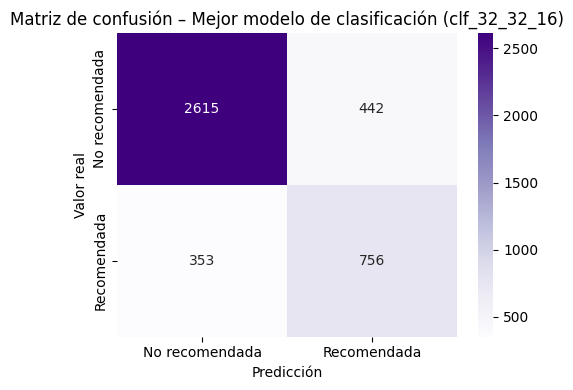


Métricas recalculadas en test (mejor modelo):
Accuracy : 0.8092
Precision: 0.6311
Recall   : 0.6817
F1-score : 0.6554
AUC ROC  : 0.8919


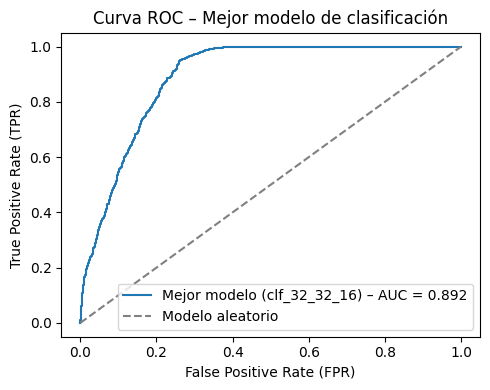

In [9]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)
import pandas as pd

# Me aseguro de tener el DataFrame de resultados ordenado por F1 (si no, lo ordeno aquí)
clf_results_df = pd.DataFrame(clf_results)
clf_results_df = clf_results_df.sort_values(by="f1_test", ascending=False)

# Elijo el mejor modelo según F1 en test
best_row = clf_results_df.iloc[0]
best_name = best_row["name"]
modelo_clf_final = best_row["model_obj"]

print("Mejor modelo de clasificación según F1 en test:", best_name)
print("\nMétricas del mejor modelo en test (del resumen de búsqueda):")
print(best_row[["acc_test", "precision_test", "recall_test", "f1_test", "auc_test"]])

# 1. Predicciones del mejor modelo en el conjunto de prueba
y_pred_prob_final = modelo_clf_final.predict(X_test_scaled, verbose=0).flatten()
y_pred_final = (y_pred_prob_final >= 0.5).astype(int)

# 2. Matriz de confusión
cm_final = confusion_matrix(y_test, y_pred_final)

print("\nMatriz de confusión (mejor modelo):")
print(cm_final)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_final,
    annot=True,
    fmt="d",
    cmap="Purples",  # matriz morada
    xticklabels=["No recomendada", "Recomendada"],
    yticklabels=["No recomendada", "Recomendada"]
)
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title(f"Matriz de confusión – Mejor modelo de clasificación ({best_name})")
plt.tight_layout()
plt.show()

# 3. Métricas recalculadas por claridad
acc = accuracy_score(y_test, y_pred_final)
prec = precision_score(y_test, y_pred_final, zero_division=0)
rec = recall_score(y_test, y_pred_final, zero_division=0)
f1 = f1_score(y_test, y_pred_final, zero_division=0)
auc = roc_auc_score(y_test, y_pred_prob_final)

print("\nMétricas recalculadas en test (mejor modelo):")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"AUC ROC  : {auc:.4f}")

# 4. Curva ROC del mejor modelo
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_final)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"Mejor modelo ({best_name}) – AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Modelo aleatorio")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Curva ROC – Mejor modelo de clasificación")
plt.legend()
plt.tight_layout()
plt.show()


ARTIFACTS PARA DASH

In [10]:
import os
import json
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)

# Carpeta donde voy a escribir los artifacts
ART_DIR = os.path.join("artifacts_clf")
os.makedirs(ART_DIR, exist_ok=True)

# === 1) Guardar el mejor modelo de clasificación ===
# modelo_clf_final viene de la búsqueda de arquitecturas (mejor F1 en test)
modelo_clf_final.save(os.path.join(ART_DIR, "modelo_clasificacion_final.keras"))

# === 2) Guardar el scaler usado en entrenamiento ===
# scaler_clf es el StandardScaler ajustado sobre X_train
joblib.dump(scaler_clf, os.path.join(ART_DIR, "scaler_clf.joblib"))

# === 3) Guardar la lista de columnas de features y algunas cosas útiles ===
# cols_features define el orden y las columnas que el modelo espera como entrada
feature_info = {
    "cols_features": cols_features,
    "nota": "Estas son las columnas (en este orden) que se usaron para entrenar el modelo de clasificación."
}

with open(os.path.join(ART_DIR, "features_clf.json"), "w") as f:
    json.dump(feature_info, f, indent=2)

# === 4) Calcular métricas y guardar resultados en JSON ===
# Uso el mejor modelo sobre el conjunto de prueba
y_pred_prob_final = modelo_clf_final.predict(X_test_scaled, verbose=0).flatten()
y_pred_final = (y_pred_prob_final >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred_final)
prec = precision_score(y_test, y_pred_final, zero_division=0)
rec = recall_score(y_test, y_pred_final, zero_division=0)
f1 = f1_score(y_test, y_pred_final, zero_division=0)
auc = roc_auc_score(y_test, y_pred_prob_final)
cm = confusion_matrix(y_test, y_pred_final)

metrics_clf = {
    "model_name": "modelo_clasificacion_final",
    "accuracy": float(acc),
    "precision": float(prec),
    "recall": float(rec),
    "f1_score": float(f1),
    "auc_roc": float(auc),
    "confusion_matrix": cm.tolist()  # lo paso a lista para que sea JSON serializable
}

with open(os.path.join(ART_DIR, "metrics_clf.json"), "w") as f:
    json.dump(metrics_clf, f, indent=2)

# === 5) Guardar predicciones sobre el test para gráficas en el dash ===
# Armo un CSV con y_real, probabilidad y clase predicha
preds_df_clf = pd.DataFrame({
    "y_true": y_test.astype(int),          # y_test ya es np.ndarray, no uso .values
    "y_prob": y_pred_prob_final,
    "y_pred": y_pred_final.astype(int)
})

preds_df_clf.to_csv(os.path.join(ART_DIR, "predictions_test_clf.csv"), index=False)

print(f"[ARTIFACTS CLF] Escritos en: {ART_DIR}")



[ARTIFACTS CLF] Escritos en: artifacts_clf
